In [1]:
# Install Pytorch
%pip install "torch==2.2.2" tensorboard

# Install Hugging Face libraries
%pip install  --upgrade "transformers==4.40.0" "datasets==2.18.0" "accelerate==0.29.3" "evaluate==0.4.1" "bitsandbytes==0.43.1" "huggingface_hub==0.22.2" "trl==0.8.6" "peft==0.10.0"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 10.4 MB/s eta 0:00:00
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-ma

In [2]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


# Imports


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F

from sklearn.metrics import f1_score, confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay

from datasets import Dataset, DatasetDict
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

import matplotlib.pyplot as plt

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)



# Load dataset

In [4]:
data = pd.read_csv('ScamDataset.csv', delimiter=',', names=['message', 'label'])

original_shape = data.shape

# Removing duplicate rows
data = data.drop_duplicates()

# Shape after removing duplicates
new_shape = data.shape

original_shape, new_shape

((20670, 2), (15241, 2))

# Preprocess

In [5]:
#data['label'] = data['label'].map({'normal': 0, 'fraud': 1})
data['label'] = data['label'].astype('category')
data['target'] = data['label'].cat.codes
data


,message,label,target
0,"Go until jurong point, crazy.. Available only ...",normal,1
1,Oh k. . I will come tomorrow,normal,1
2,There was an error with your subscription. Ple...,fraud,0
3,Well if I'm that desperate I'll just call arma...,normal,1
4,That's the trouble with classes that go well -...,normal,1
...,...,...,...
20664,Important notice: Your tax refund requires urg...,fraud,0
20665,Important notice: Your tax refund requires urg...,fraud,0
20666,"amount of $2,798 to cancel your order or to co...",fraud,0
20668,Important notice: Your tax refund requires urg...,fraud,0


In [6]:
# Decode
data['label'].cat.categories
category_map = {code: category for code, category in enumerate(data['label'].cat.categories)}
category_map

{0: 'fraud', 1: 'normal'}

In [7]:
train_end_point = int(data.shape[0]*0.6)
val_end_point = int(data.shape[0]*0.8)
df_train = data.iloc[:train_end_point,:]
df_val = data.iloc[train_end_point:val_end_point,:]
df_test = data.iloc[val_end_point:,:]
print(df_train.shape, df_test.shape, df_val.shape)

(9144, 3) (3049, 3) (3048, 3)


### Convert from Pandas DataFrame to Hugging Face Dataset
* Also let's shuffle the training set.
* We put the components train,val,test into a DatasetDict so we can access them later with HF trainer.
* Later we will add a tokenized dataset


In [8]:
# Converting pandas DataFrames into Hugging Face Dataset objects:
dataset_train = Dataset.from_pandas(df_train.drop('label',axis=1))
dataset_val = Dataset.from_pandas(df_val.drop('label',axis=1))
dataset_test = Dataset.from_pandas(df_test.drop('label',axis=1))


In [9]:
# Shuffle the training dataset
dataset_train_shuffled = dataset_train.shuffle(seed=42)  # Using a seed for reproducibility

In [10]:
# Combine them into a single DatasetDict
dataset = DatasetDict({
    'train': dataset_train_shuffled,
    'val': dataset_val,
    'test': dataset_test
})
dataset

DatasetDict({
    train: Dataset({
        features: ['message', 'target', '__index_level_0__'],
        num_rows: 9144
    })
    val: Dataset({
        features: ['message', 'target', '__index_level_0__'],
        num_rows: 3048
    })
    test: Dataset({
        features: ['message', 'target', '__index_level_0__'],
        num_rows: 3049
    })
})

In [11]:
dataset['train']

Dataset({
    features: ['message', 'target', '__index_level_0__'],
    num_rows: 9144
})

In [12]:
df_train.target.value_counts(normalize=True)

target
0    0.501859
1    0.498141
Name: proportion, dtype: float64

In [13]:
class_weights=(1/df_train.target.value_counts(normalize=True).sort_index()).tolist()
class_weights=torch.tensor(class_weights)
class_weights=class_weights/class_weights.sum()
class_weights


tensor([0.4981, 0.5019])

In [14]:
model_name = "meta-llama/Meta-Llama-3-8B"

In [15]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True, # enable 4-bit quantization
    bnb_4bit_quant_type = 'nf4', # information theoretically optimal dtype for normally distributed weights
    bnb_4bit_use_double_quant = True, # quantize quantized weights //insert xzibit meme
    bnb_4bit_compute_dtype = torch.bfloat16 # optimized fp format for ML
)

In [16]:
lora_config = LoraConfig(
    r = 16, # the dimension of the low-rank matrices
    lora_alpha = 8, # scaling factor for LoRA activations vs pre-trained weight activations
    target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj'],
    lora_dropout = 0.05, # dropout probability of the LoRA layers
    bias = 'none', # wether to train bias weights, set to 'none' for attention layers
    task_type = 'SEQ_CLS'
)

In [17]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    num_labels=2
)

model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )


In [18]:
model = prepare_model_for_kbit_training(model)
model

LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )


In [19]:
model = get_peft_model(model, lora_config)
model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): LlamaForSequenceClassification(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
        

#Load Tokenizer

In [20]:
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [21]:
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False
model.config.pretraining_tp = 1

# Loop through dataset to measure performance before training/fitting the model

In [22]:
messages = df_test.message.tolist()
messages[0:2]

['Important notice: Your tax refund requires urgent attention. Act without delay to avoid issues. Ref: 5878',
 'Important notice: Your tax refund requires urgent attention. Act as soon as possible to avoid issues. Ref: 708']

In [23]:
# Convert summaries to a list
messages = df_test.message.tolist()

# Define the batch size
batch_size = 32  # You can adjust this based on your system's memory capacity

# Initialize an empty list to store the model outputs
all_outputs = []

# Process the sentences in batches
for i in range(0, len(messages), batch_size):
    # Get the batch of sentences
    batch_messages = messages[i:i + batch_size]

    # Tokenize the batch
    inputs = tokenizer(batch_messages, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Move tensors to the device where the model is (e.g., GPU or CPU)
    inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

    # Perform inference and store the logits
    with torch.no_grad():
        outputs = model(**inputs)
        all_outputs.append(outputs['logits'])


In [24]:
final_outputs = torch.cat(all_outputs, dim=0)
final_outputs

tensor([[1.8341, 3.0805],
        [4.6773, 1.0203],
        [2.0628, 3.0271],
        ...,
        [0.1561, 1.9300],
        [1.8638, 3.2014],
        [1.8385, 3.1974]], device='cuda:0')

In [25]:
final_outputs.argmax(axis=1)

tensor([1, 0, 1,  ..., 1, 1, 1], device='cuda:0')

In [26]:
df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
df_test['predictions']

<ipython-input-26-7c1d2547ae19>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()


15486    1
15487    0
15488    1
15492    1
15493    0
        ..
20664    1
20665    1
20666    1
20668    1
20669    1
Name: predictions, Length: 3049, dtype: int64

In [27]:
df_test['predictions'].value_counts()

predictions
1    1529
0    1520
Name: count, dtype: int64

In [28]:
df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])
df_test['predictions']

<ipython-input-28-b56fb9d5a919>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


15486    normal
15487     fraud
15488    normal
15492    normal
15493     fraud
          ...  
20664    normal
20665    normal
20666    normal
20668    normal
20669    normal
Name: predictions, Length: 3049, dtype: object

# Evaluate Performance

In [29]:
def get_performance_metrics(df_test):
  y_test = df_test.label
  y_pred = df_test.predictions

  y_test = y_test.astype('category')
  y_pred = y_pred.astype('category')

  y_test = y_test.cat.codes
  y_pred = y_pred.cat.codes

  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)

  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1-Score: {f1:.4f}")

  print("Confusion Matrix:")
  print(confusion_matrix(y_test, y_pred))

  print("\nClassification Report:")
  print(classification_report(y_test, y_pred))

  print("Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred))
  print("Accuracy Score:", accuracy_score(y_test, y_pred))

  # Plot confusion matrix
  labels = ['normal', 'fraud']
  cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap=plt.cm.Blues)
  plt.title(f'Confusion Matrix: {model_name}')
  plt.show()

# Results without fined tune


Accuracy: 0.3460
Precision: 0.1982
Recall: 0.2829
F1-Score: 0.2331
Confusion Matrix:
[[ 752 1226]
 [ 768  303]]

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.38      0.43      1978
           1       0.20      0.28      0.23      1071

    accuracy                           0.35      3049
   macro avg       0.35      0.33      0.33      3049
weighted avg       0.39      0.35      0.36      3049

Balanced Accuracy Score: 0.3315475836441756
Accuracy Score: 0.3460150869137422


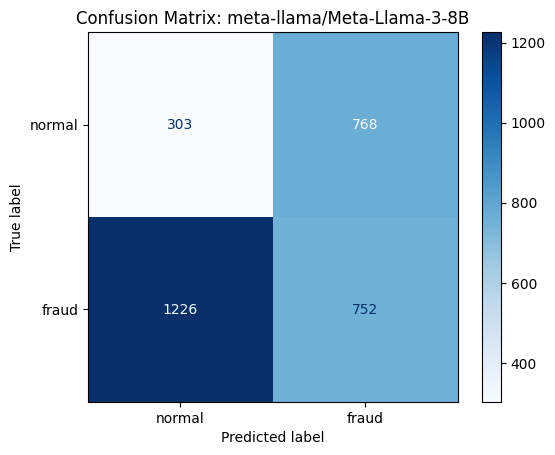

In [30]:
get_performance_metrics(df_test)

In [31]:
MAX_LEN = 512
col_to_delete = ['message','__index_level_0__']

def llama_preprocessing_function(examples):
    return tokenizer(examples['message'], truncation=True, max_length=MAX_LEN)

tokenized_datasets = dataset.map(llama_preprocessing_function, batched=True, remove_columns=col_to_delete)
tokenized_datasets = tokenized_datasets.rename_column("target", "label")
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/9144 [00:00<?, ? examples/s]

Map:   0%|          | 0/3048 [00:00<?, ? examples/s]

Map:   0%|          | 0/3049 [00:00<?, ? examples/s]

In [32]:
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)


In [33]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'balanced_accuracy' : balanced_accuracy_score(predictions, labels),'accuracy':accuracy_score(predictions,labels)}

# Define Custom trainer


In [34]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        # Ensure label_weights is a tensor
        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False):
        # Extract labels and convert them to long type for cross_entropy
        labels = inputs.pop("labels").long()

        # Forward pass
        outputs = model(**inputs)

        # Extract logits assuming they are directly outputted by the model
        logits = outputs.get('logits')

        # Compute custom loss with class weights for imbalanced data handling
        if self.class_weights is not None:
            loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [35]:
training_args = TrainingArguments(
    output_dir = 'sentiment_classification',
    learning_rate = 1e-4,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    num_train_epochs = 3,
    weight_decay = 0.01,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True
)

In [36]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['val'],
    tokenizer = tokenizer,
    data_collator = collate_fn,
    compute_metrics = compute_metrics,
    class_weights=class_weights,
)

<ipython-input-34-1bea759fa04e>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)


In [37]:
train_result = trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Balanced Accuracy,Accuracy
1,0.034400,0.026185,0.994546,0.994423
2,0.003100,0.021516,0.996253,0.996391
3,0.000000,0.027089,0.995867,0.996063


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


In [38]:
def make_predictions(model,df_test):


  # Convert summaries to a list
  messages = df_test.message.tolist()

  # Define the batch size
  batch_size = 32  # You can adjust this based on your system's memory capacity

  # Initialize an empty list to store the model outputs
  all_outputs = []

  # Process the sentences in batches
  for i in range(0, len(messages), batch_size):
      # Get the batch of sentences
      batch_messages = messages[i:i + batch_size]

      # Tokenize the batch
      inputs = tokenizer(batch_messages, return_tensors="pt", padding=True, truncation=True, max_length=512)

      # Move tensors to the device where the model is (e.g., GPU or CPU)
      inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

      # Perform inference and store the logits
      with torch.no_grad():
          outputs = model(**inputs)
          all_outputs.append(outputs['logits'])
  final_outputs = torch.cat(all_outputs, dim=0)
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


make_predictions(model,df_test)

<ipython-input-38-9b1f55edc54d>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
<ipython-input-38-9b1f55edc54d>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


Accuracy: 0.9957
Precision: 0.9907
Recall: 0.9972
F1-Score: 0.9940
Confusion Matrix:
[[1968   10]
 [   3 1068]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1978
           1       0.99      1.00      0.99      1071

    accuracy                           1.00      3049
   macro avg       0.99      1.00      1.00      3049
weighted avg       1.00      1.00      1.00      3049

Balanced Accuracy Score: 0.9960716339114007
Accuracy Score: 0.995736306985897


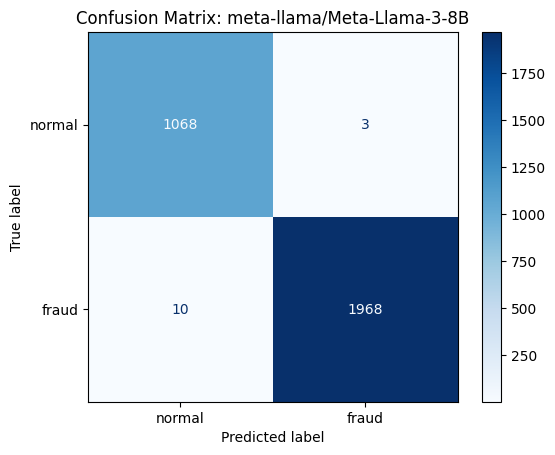

In [39]:
get_performance_metrics(df_test)

In [40]:
metrics = train_result.metrics
max_train_samples = len(dataset_train)
metrics["train_samples"] = min(max_train_samples, len(dataset_train))
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =        3.0
  total_flos               = 62436867GF
  train_loss               =     0.0236
  train_runtime            = 3:36:54.55
  train_samples            =       9144
  train_samples_per_second =      2.108
  train_steps_per_second   =      0.263


In [42]:
trainer.save_model("saved_model")